<a href="https://colab.research.google.com/github/jpequegn/wkoAnalysis/blob/master/notebooks/PDC%20Curve%20Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bike / Run Power Duration Curve fitting

In [1]:
!pip install -q torch torchvision numpy pandas matplotlib lmfit

     |████████████████████████████████| 292 kB 5.3 MB/s 
     |████████████████████████████████| 98 kB 4.9 MB/s 


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model, Parameters

# Import the data from a CSV (Secs, Watts)

In [4]:
df = pd.read_csv("./mmpcurve-bike-403.csv")

## Let's try to implement the WKO model
The model seems to follow the following formula: P(t) = FRC / t * (1-exp(-t/tau)) + FTP * (1-exp(-t/tau2))
       [-a * Ln(t/TTE) if t>TTE]
       
       
FRC: Functional Reserve Capacity

FTP: Functional Threshold Power

TTE: Time To Exhaustion

Other parameters have less direct traceability / meaning but lim(tau, t->0) is close to FRC/Pmax

## 1st option: Using LMFIT

In [6]:
def power_curve(x, frc, ftp, tte, tau, tau2, a):
    p = frc / x * (1.0 - np.exp(-x / tau)) + ftp * (1 - np.exp(-x / tau2))
    p -= np.maximum(0, a * np.log(x / tte))
    return p

In [7]:
def fit_curve(df_x, df_y, maxtau=20):

    gmodel = Model(power_curve)
    params = Parameters()
    params.add('frc', value=5000, min=1, max=15000)
    params.add('ftp', value=200, min=150, max=400)
    params.add('tte', value=2000, min=1200)
    params.add('tau', value=12, min=10, max=maxtau)
    params.add('tau2', value=30, min=10)
    params.add('a', value=10, min=10, max=200)
    
    result = gmodel.fit(df_y, params, x=df_x)
    fit = power_curve(df_x, result.best_values['frc'], result.best_values['ftp'], 
                  result.best_values['tte'], result.best_values['tau'],
                  result.best_values['tau2'], result.best_values['a'])

    return result, fit

In [8]:
df_x = df['Secs']
df_y = df['Watts']

In [9]:
gmodel = Model(power_curve)
print('parameter names: {}'.format(gmodel.param_names))
print('independent variables: {}'.format(gmodel.independent_vars))

parameter names: ['frc', 'ftp', 'tte', 'tau', 'tau2', 'a']
independent variables: ['x']


In [10]:
result, fit = fit_curve(df_x, df_y)
result.best_values

{'a': 13.782689051292195,
 'frc': 13814.09327782722,
 'ftp': 232.88977254630836,
 'tau': 17.75105160939912,
 'tau2': 36.23381192581746,
 'tte': 2109.9405595597723}

In [11]:
# %matplotlib widget

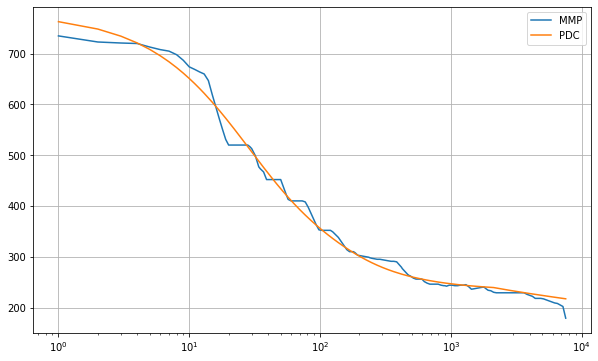

In [12]:
plt.figure(figsize=(10,6))
plt.plot(df_x, df_y, label='MMP')
plt.plot(df_x, fit, label='PDC')
plt.legend()
plt.grid(True)
plt.xscale('log')

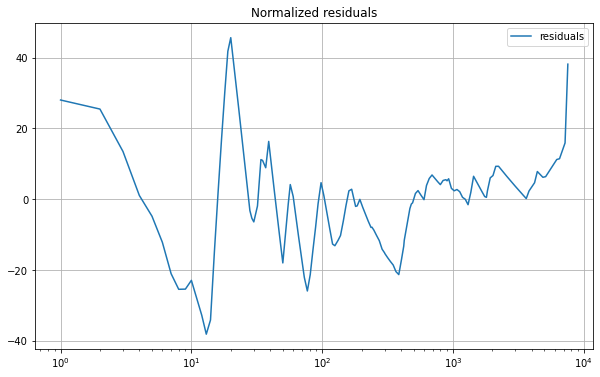

In [13]:
plt.ion()
plt.figure(figsize=(10,6))
# fig, ax = plt.subplots()
plt.plot(df_x, result.residual, label='residuals')
plt.grid(True)
plt.title('Normalized residuals')
plt.legend()
plt.xscale('log')

# What-if Analysis

In [14]:
def addNewBest(df, sec, watt):
    newbest = (df['Secs']<sec) & (df['Watts']<watt)
    df.loc[newbest, "Watts"] = watt

In [15]:
df_temp = df.copy(deep=True)

In [16]:
# Add some new bests to the MMP curve - then calculate the impact on FRC, FTP and TTE
# addNewBest(df_temp, 30, 480)
addNewBest(df_temp, 1200, 225)

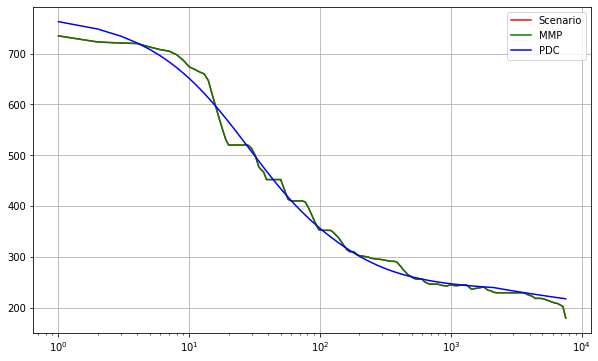

In [17]:
plt.figure(figsize=(10,6))
plt.plot(df_x, df_temp['Watts'], label='Scenario', color='r')
plt.plot(df_x, df['Watts'], label='MMP', color='g')
plt.plot(df_x, fit, label='PDC', color='b')
plt.grid(True)
plt.legend()
plt.xscale('log')

In [18]:

result_scen, fit_scen = fit_curve(df_temp['Secs'], df_temp['Watts'], maxtau=16)
result.best_values, result_scen.best_values

({'a': 13.782689051292195,
  'frc': 13814.09327782722,
  'ftp': 232.88977254630836,
  'tau': 17.75105160939912,
  'tau2': 36.23381192581746,
  'tte': 2109.9405595597723},
 {'a': 30.628641543253067,
  'frc': 12671.82568719679,
  'ftp': 240.6939450876652,
  'tau': 15.999998641105863,
  'tau2': 31.648658209173153,
  'tte': 1352.1540738225322})

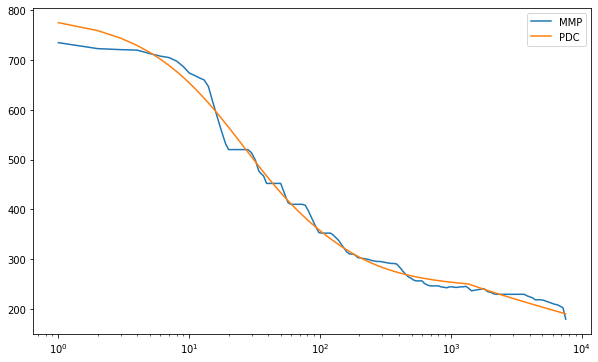

In [19]:
plt.figure(figsize=(10,6))
plt.plot(df_temp['Secs'], df_temp['Watts'], label='MMP')
plt.plot(df_temp['Secs'], fit_scen, label='PDC')
plt.legend()
plt.xscale('log')

In [20]:
sec = 1200
watt = 256
newbest = (df['Secs']<sec) & (df['Watts']<watt)
test = df.loc[newbest]
print(test.index[-1:]+1)

Int64Index([115], dtype='int64')


## 2nd option: Approximate the PDC with a FC neural net

Basic implementation in Pytorch

In [21]:
inp = 1
hidden = 30
out = 1
lr = 1e-3

In [22]:
model = torch.nn.Sequential(
    torch.nn.Linear(inp, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, out)
)

In [23]:
loss_fn = torch.nn.MSELoss(reduction='sum')

In [24]:
# Generate some training data based on the true function
x = torch.tensor(df['Secs'].values.astype(np.float32).reshape(len(df),1))
y = torch.tensor(df['Watts'].values.astype(np.float32).reshape(len(df),1))


In [25]:
optim = torch.optim.Adam(model.parameters(), lr = lr)

In [26]:
for i in range(30001):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    if (i%5000)==0:
        print('Epoch {}, Loss: {:2f}'.format(i, loss.item()))
    
    optim.zero_grad()
    loss.backward()
    optim.step()

Epoch 0, Loss: 28625062.000000
Epoch 5000, Loss: 21393.076172
Epoch 10000, Loss: 14723.916992
Epoch 15000, Loss: 19563.398438
Epoch 20000, Loss: 24560.171875
Epoch 25000, Loss: 4990.074219
Epoch 30000, Loss: 7670.545410


In [27]:
model.eval()

Sequential(
  (0): Linear(in_features=1, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=30, bias=True)
  (3): ReLU()
  (4): Linear(in_features=30, out_features=30, bias=True)
  (5): ReLU()
  (6): Linear(in_features=30, out_features=1, bias=True)
)

In [28]:
predicted_tensor = model(x)
predicted = predicted_tensor.detach().numpy()

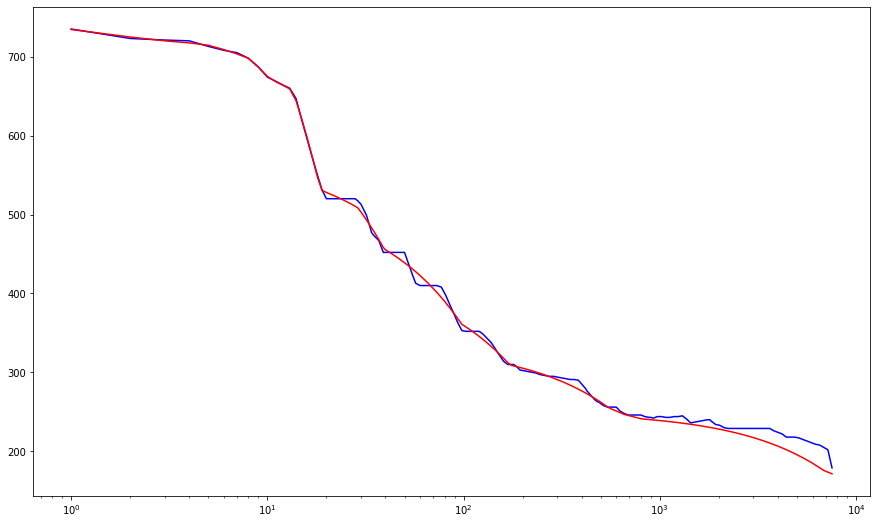

In [29]:
plt.figure(figsize=(15,9))
plt.plot(x, y, label='orig', c='b')
plt.plot(x, predicted, label='predict', c='r')
plt.xscale('log')

In [30]:
# What is the predicted power at 10 mins
test = torch.tensor(np.array([[600,]], dtype=np.float32))
predict = model(test)
predict

tensor([[251.1483]], grad_fn=<AddmmBackward0>)

## 3rd option: Use Pytorch autograd to fit the power curve

In [31]:
def power(x):
    p = frc / x * (1.0 - np.exp(-x / tau)) + ftp * (1 - np.exp(-x / tau2))
    p -= np.maximum(0, a * np.log(x/tmap))
    return p

In [32]:
frc = torch.ones(1, dtype=torch.float, requires_grad=True)
ftp = torch.ones(1, dtype=torch.float, requires_grad=True)
tau = 14.7
tau2 = 40
tmap = 1450
a = 22

In [33]:
optim = torch.optim.Adam([frc, ftp], lr = 0.1)

In [34]:
loss_fn = torch.nn.MSELoss(reduction='sum')

In [35]:
# Generate some training data based on the true function
x = torch.tensor(df['Secs'].values.astype(np.float32).reshape(len(df),1))
y = torch.tensor(df['Watts'].values.astype(np.float32).reshape(len(df),1))

In [37]:
for i in range(100000):
    y_pred = power(x)
    loss = loss_fn(y_pred, y)
    if (i%10000)==0:
        print('Epoch {}, Loss: {:2f}'.format(i, loss.item()))
    
    optim.zero_grad()
    loss.backward()
    optim.step()

Epoch 0, Loss: 435758.843750
Epoch 10000, Loss: 195512.062500
Epoch 20000, Loss: 74020.343750
Epoch 30000, Loss: 52005.722656
Epoch 40000, Loss: 52005.667969
Epoch 50000, Loss: 52005.687500
Epoch 60000, Loss: 52005.679688
Epoch 70000, Loss: 52005.679688
Epoch 80000, Loss: 52005.671875
Epoch 90000, Loss: 52005.679688


In [38]:
frc, ftp

(tensor([12266.5078], requires_grad=True),
 tensor([245.3147], requires_grad=True))

In [ ]:
predicted_tensor = power(x)
predicted = predicted_tensor.detach().numpy()

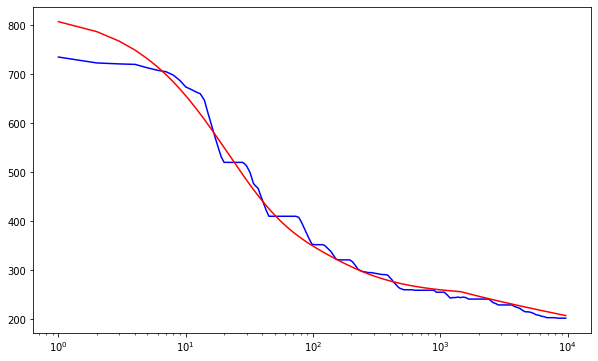

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x, y, label='orig', c='b')
plt.plot(x, predicted, label='predict', c='r')
plt.xscale('log')